### Building a Classification Model using Neural network

In [1]:
import pandas as pd

In [2]:
titanic_data = pd.read_csv('datasets/titanic_data/train.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_data = titanic_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', #Dropping unwanted features
                                 'SibSp', 'Parch', 'Embarked'],
                                axis=1)
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


In [4]:
titanic_data = titanic_data.dropna()

In [5]:
from sklearn import preprocessing

In [6]:
#Encode categorical values to numeric form
le = preprocessing.LabelEncoder() #Label encoder

In [7]:
titanic_data['Sex'] = le.fit_transform(titanic_data['Sex'])
titanic_data.head()

,Survived,Pclass,Sex,Age,Fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [8]:
titanic_features = titanic_data[['Pclass', 'Sex', 'Age', 'Fare']]
titanic_features.head()

,Pclass,Sex,Age,Fare
0,3,1,22.0,7.2500
1,1,0,38.0,71.2833
2,3,0,26.0,7.9250
3,1,0,35.0,53.1000
4,3,1,35.0,8.0500


In [9]:
#One Hot Encoding (more than 3 values)
titanic_features = pd.get_dummies(titanic_features, columns=['Pclass'])
titanic_features.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,7.2500,0,0,1
1,0,38.0,71.2833,1,0,0
2,0,26.0,7.9250,0,0,1
3,0,35.0,53.1000,1,0,0
4,1,35.0,8.0500,0,0,1


In [11]:
titanic_target = titanic_data[['Survived']]
titanic_target.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(titanic_features,
                                                   titanic_target,
                                                   test_size=0.2,
                                                   random_state=0)

In [13]:
x_train.shape, y_train.shape

((571, 6), (571, 1))

In [14]:
import torch
import numpy as np

In [15]:
xtrain_ = torch.from_numpy(x_train.values).float()
xtest_ = torch.from_numpy(x_test.values).float()

In [16]:
xtrain_.shape

torch.Size([571, 6])

We will use the NLL loss function for our Classification Model. We need to reshape our y-labels to match the format that our loss function requires. We reshape the y-labels for both training and test data as a 1-D tensor - a single row containing all the labels

In [17]:
ytrain_ = torch.from_numpy(y_train.values).view(1,-1)[0]
ytest_ = torch.from_numpy(y_test.values).view(1,-1)[0]

In [18]:
ytrain_.shape

torch.Size([571])

In [20]:
#Imports for building NN
import torch.nn as nn
import torch.nn.functional as F

In [21]:
input_size = 6
output_size = 2 #Whether the passenger survived or not
hidden_size = 10

In [22]:
#Building our custom NN module by subclassing the nn.Module class
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__() #Calling superclass to initialise our neural network befor we add our layers
        
        #3 linear, fully-connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x): #Define forward pass implementation on x features
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=-1) #Dimension is inferred

In [23]:
model = Net()

In [25]:
#Use an Optimiser
import torch.optim as optim

optimiser = optim.Adam(model.parameters()) #Adam optimiser

loss_fn = nn.NLLLoss()

In [26]:
epoch_data = []
epochs = 1001

In [33]:
for epoch in range(1, epochs):
    
    #Forward pass
    optimiser.zero_grad() #Calculate fresh gradients for every epoch
    ypred = model(xtrain_)
    
    #Backward pass
    loss = loss_fn(ypred, ytrain_) #Calculate the loss on the prediction
    loss.backward() #Calculate gradients
    
    optimiser.step() #Update model parameters
    
    #Calculate the loss on our test data to see how the model performs
    ypred_test = model(xtest_)
    loss_test = loss_fn(ypred_test, ytest_)
    
    #Predicted output is in the form of probability
    #Actual predicted labels - the output that corresponds to the highest probability
    _, pred = ypred_test.data.max(1)
    
    #Printing the accuracy of the predictions on the test data as well as the current loss
    #accuracy - whether the predicted class matches the actual label; divide it by total number of instancesin the test data
    accuracy = pred.eq(ytest_.data).sum().item() / y_test.values.size
    epoch_data.append([epoch, loss.data.item(), loss_test.data.item(), accuracy])
    
    if epoch % 100 == 0:
        print('epoch - %d (%d%%) train loss - %.2f test loss - %.2f accuracy - %.4f' \
              % (epoch, epoch/150 *10, loss.data.item(), loss_test.data.item(), accuracy))

epoch - 100 (6%) train loss - 0.48 test loss - 0.45 accuracy - 0.8182
epoch - 200 (13%) train loss - 0.44 test loss - 0.42 accuracy - 0.8392
epoch - 300 (20%) train loss - 0.43 test loss - 0.41 accuracy - 0.8182
epoch - 400 (26%) train loss - 0.41 test loss - 0.40 accuracy - 0.8182
epoch - 500 (33%) train loss - 0.41 test loss - 0.40 accuracy - 0.8252
epoch - 600 (40%) train loss - 0.40 test loss - 0.40 accuracy - 0.8322
epoch - 700 (46%) train loss - 0.39 test loss - 0.40 accuracy - 0.8531
epoch - 800 (53%) train loss - 0.39 test loss - 0.41 accuracy - 0.8531
epoch - 900 (60%) train loss - 0.39 test loss - 0.42 accuracy - 0.8531
epoch - 1000 (66%) train loss - 0.38 test loss - 0.43 accuracy - 0.8601


In [34]:
df_epochs_data = pd.DataFrame(epoch_data,
                             columns=['epoch', 'train_loss', 'test_loss', 'accuracy'])

In [35]:
import matplotlib.pyplot as plt

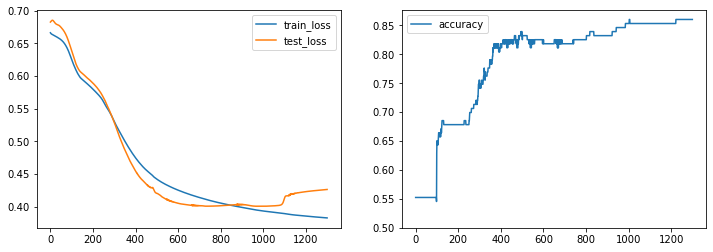

In [37]:
#Visualise the losses and accuracy
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_epochs_data[['train_loss', 'test_loss']].plot(ax=ax1)
df_epochs_data[['accuracy']].plot(ax=ax2)
plt.ylim(ymin=0.5)

plt.show()

### Test Data Submission

In [53]:
titanic_test_data = pd.read_csv('datasets/titanic_data/test.csv')
titanic_test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
titanic_test = titanic_test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', #Dropping unwanted features
                                 'SibSp', 'Parch', 'Embarked'],
                                axis=1)
titanic_test.head()

,Pclass,Sex,Age,Fare
0,3,male,34.5,7.8292
1,3,female,47.0,7.0000
2,2,male,62.0,9.6875
3,3,male,27.0,8.6625
4,3,female,22.0,12.2875


In [40]:
titanic_test['Sex'] = le.fit_transform(titanic_test['Sex'])
titanic_test.head()

,Pclass,Sex,Age,Fare
0,3,1,34.5,7.8292
1,3,0,47.0,7.0000
2,2,1,62.0,9.6875
3,3,1,27.0,8.6625
4,3,0,22.0,12.2875


In [41]:
titanic_test = pd.get_dummies(titanic_test, columns=['Pclass'])
titanic_test.head()

,Sex,Age,Fare,Pclass_1,Pclass_2,Pclass_3
0,1,34.5,7.8292,0,0,1
1,0,47.0,7.0000,0,0,1
2,1,62.0,9.6875,0,1,0
3,1,27.0,8.6625,0,0,1
4,0,22.0,12.2875,0,0,1


In [45]:
test_tensor = torch.tensor(titanic_test.values).float()

In [50]:
preds = model(test_tensor)

_, pred = preds.data.max(1)

C:\Users\AB15\Anaconda3\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [51]:
final_preds = pred.detach().numpy()

In [55]:
submission = pd.DataFrame(titanic_test_data['PassengerId'])

In [56]:
submission['Survived'] = final_preds

In [61]:
submission = submission.set_index('PassengerId')

In [62]:
submission.head()

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [63]:
submission.to_csv('titanic_submission.csv')